In [1]:
#from skfem import *

import numpy as np
import scipy
import skfem    # scikit-fem
#https://scikit-fem.readthedocs.io/en/latest/index.html

import matplotlib.pyplot as plt
import importlib  # for reloading routines
%matplotlib inline


### The Brussellator model on a triangular mesh of the circle with von Neumann boundary condition !

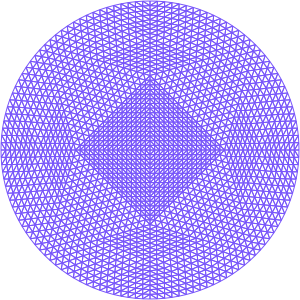

In [4]:

from math import ceil
from typing import Iterator, Tuple

import numpy as np
from scipy.sparse.linalg import splu  # for sparse matrices, 
# returns something like invA with LU decomp which can be applied with solve to solve Ax = b for x

#from skfem import *
from skfem.models.poisson import laplace, mass

from skfem.visuals.matplotlib import plot

mcirc= skfem.MeshTri.init_circle(5,smoothed=False)  # make a triangular mesh of the unit circle, 5 is refinement
mcirc # show the mesh

In [6]:
element = skfem.ElementTriP1()  # or ElementTriP2?  a triangular element
basis = skfem.Basis(mcirc, element)

D_u  = 2.e-3  #diffusion coefficients 
D_v = D_u*11
dt = .002    # timestep 

L_1 = D_u * skfem.asm(laplace, basis)   # Laplacian for u field 
L_2 = D_v * skfem.asm(laplace, basis)   # for v field 
M = skfem.asm(mass, basis)  # mass matrix (sizes of triangles) 

#L0, M0 = penalize(L, M, D=basis.get_dofs())  # sets boundary to zero Dirichlet boundary 
#L0=L;  #M0=M;
# ACQ otherwise gives von Neuman boundary condition!!!!!! 

theta = 0.5                     # Crank–Nicolson algorithm for a diffusive PDE
A_1 = M + theta * L_1 * dt
B_1 = M - (1 - theta) * L_1 * dt
A_2 = M + theta * L_2 * dt
B_2 = M - (1 - theta) * L_2 * dt

backsolve_1 = splu(A_1.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)
backsolve_2 = splu(A_2.T).solve
# backsolve(B @ u) probably gives A^-1 (B u) but with LU decomp
# solve for x such that Ax = Bu computed using LU decomp of A
# see https://en.wikipedia.org/wiki/LU_decomposition and 
# https://docs.scipy.org/doc/scipy-1.14.0/reference/generated/scipy.sparse.linalg.splu.html

In [8]:
# make random initial conditions for u,v fields 
nnodes = len(basis.doflocs[0])
u_init = np.random.random(nnodes)*0.05
v_init = np.random.random(nnodes)*0.05


In [10]:
# Reaction parts of differential equations for 
# three different types of different Reaction diffusion equations
# u,v are 2D arrays or fields, alpha, beta could be numbers or arrays with same dimension as fields
# rdtype is a string specifying the model
def Reaction(u,v,alpha,beta,rdtype):
    if (rdtype == 'FN'):  # FitzHugh Nagumo model
        Ru,Rv=R_FN(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br'):  # Brusellator model
        Ru,Rv= R_Br(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS'):  # Gray-Scott model
        Ru,Rv = R_GS(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Heat'):  # Heat equation 
        n = len(u)
        Ru = np.zeros(n); Rv = np.zeros(n)
        return Ru,Rv
    print('invalid reaction type')

#The FitzHugh-Nagumo Reaction Diffusion Model
# example: Du, Dv, alpha, beta = 1, 100, 0.5, 20, dt=0.0002, dx = 1
def R_FN(u,v,alpha,beta): 
    Ru =  u - u**3 - v + alpha 
    Rv = (u - v)*beta
    return Ru,Rv
    
# Brusselator Reaction Diffusion model
# example: Du, Dv, alpha, beta = 2, 22, 5, 9 # dt=0.005, dx=1
# u = alpha is a fixed point of R
def R_Br(u,v,alpha,beta): 
    Ru = alpha - (beta+1)*u + (u**2)*v    
    Rv = beta*u - (u**2)*v
    return Ru,Rv

# The Gray-Scott Reaction Diffusion model
# alpha is feed rate for u, beta is kill or drain rate
# alpha kills v
# example: Du = 0.2, Dv = Du/2, alpha = 0.037 and beta = 0.06 , dx=1
def R_GS(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*(1-u) 
    Rv =  u*(v**2) -(alpha+ beta)*v
    return Ru,Rv

In [18]:
# display u,v  fields 
def disp(mesh,u,v,basis,t):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)
    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')
    ax_j0 = plot(mesh, u[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax0)
    ax_j1 = plot(mesh, v[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax1)
    fig = ax0.get_figure()
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  # vertex-based temperature-colour
    fig.colorbar(field0)
    fig.colorbar(field1)
    title = ax0.set_title(f'u,  $t$ = {t:.3f}')
    title = ax1.set_title(f'v')


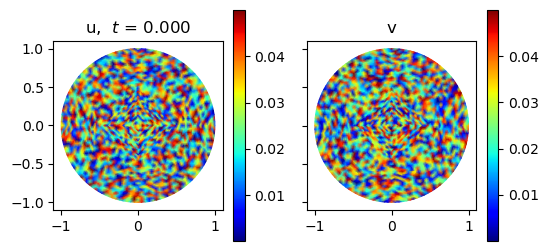

In [20]:
# show initial conditions 
t=0
disp(mcirc,u_init,v_init,basis,t)

In [22]:
# split integrator, crank nicholson for the reaction parts and simply adding in the 
# function terms by hand afterwards 
# do a single timestep, return u,v fields and time 
# requires globals: alpha, beta, rdtype, dt, backsolve_1, backsolve_2, B_1, B_2 
def one_step(t,u,v):
    t += dt
    Ru,Rv = Reaction(u,v,alpha,beta,rdtype)
    u = backsolve_1(B_1 @ u)    
    v = backsolve_2(B_2 @ v)  
    u += Ru*dt
    v += Rv*dt
    return t,u,v

In [24]:
u = u_init; v = v_init; t=0; 
rdtype = 'Br'
alpha = 5.; beta = 9.  # choose some nice Brusselator params

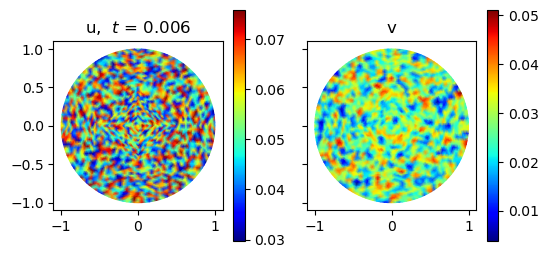

In [26]:
for i in range(3):
    t, u, v = one_step(t,u,v)  
disp(mcirc,u,v,basis,t)

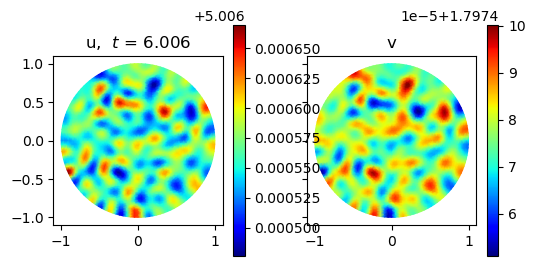

In [28]:
for i in range(3000):
    t, u, v = one_step(t,u,v)  
disp(mcirc,u,v,basis,t)

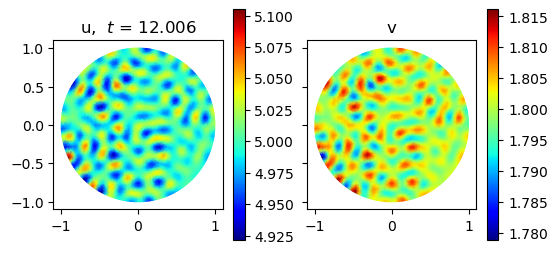

In [30]:
for i in range(3000):
    t, u, v = one_step(t,u,v)  
disp(mcirc,u,v,basis,t)

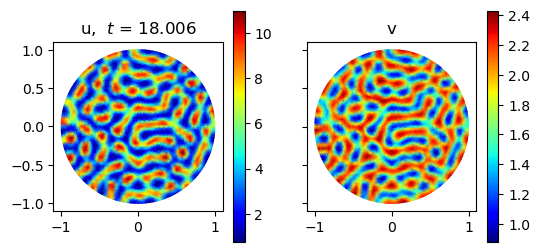

In [32]:
for i in range(3000):
    t, u, v = one_step(t,u,v)  
disp(mcirc,u,v,basis,t)

In [ ]:
# looks like it should! patterns have grown 